# 1. Library Imports
We used pandas, numpy, seaborn, sklearn and XGBClassifier.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, label_binarize

from xgboost import XGBClassifier


# 2. Data pre-processing
The data columns are split into categorical and numeric columns.

Then the features are separated from the target.

We split the data into test and trains (20-80 split).

Finally, we create a pre-processing pipeline.

## Features
- **Gender:** Individual's gender (Male or Female)
- **Age:** Age in years
- **Height:** Height in metres.
- **Weight**: Weight in kilograms.  
- **FCVC** (Frequency of Consumption of Vegetables): How often vegetables are consumed.  
- **NCP** (Number of Main Meals per Day): Number of main meals eaten per day.  
- **CH2O** (Daily Water Intake): Amount of water consumed per day in litres.  
- **FAF** (Frequency of Physical Activity): How often physical activity is performed weekly.  
- **FAVC** (Frequent Consumption of High-Caloric Food): Whether high-calorie foods are frequently consumed.  
- **CAEC** (Consumption of Food Between Meals): Frequency of snacking between meals.  
- **NObeyesdad** (Target): Obesity level category, reclassified into `Normal_Weight`, `Overweight`, and `Obesity`.  

In [3]:
df = pd.read_csv("AI/train.csv")
df = df.dropna(axis=0)

df['NObeyesdad'] = df['NObeyesdad'].replace({
    'Overweight_Level_I': 'Overweight',
    'Overweight_Level_II': 'Overweight',
    'Obesity_Type_I':      'Obesity',
    'Obesity_Type_II':     'Obesity',
    'Obesity_Type_III':    'Obesity'
})
categorical_cols = ['Gender', 'FAVC', 'CAEC']
numeric_cols     = ['Age','Height','Weight','FCVC','NCP','CH2O','FAF']


X = df[['Gender', 'Age', 'Height', 'Weight', 'FAVC', 'FCVC', 'NCP', 'CH2O', 'FAF', 'CAEC']]
y = df['NObeyesdad']
le_target = LabelEncoder()
y = le_target.fit_transform(y)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
    ('std', StandardScaler(), numeric_cols)
])
X_train_t = preprocessor.fit_transform(X_train)
X_test_t  = preprocessor.transform(X_test)

y_test_bin = label_binarize(y_test, classes=range(len(le_target.classes_)))

# 3. Training and Evaluating function
Here we have a function that, when passed a model, trains it and returns a report.

In [4]:
def train_and_evaluate_model(model, model_name):

    model.fit(X_train_t, y_train)
    y_pred = model.predict(X_test_t)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {accuracy:.4f}")
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le_target.classes_,
                yticklabels=le_target.classes_)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test_t)  
        y_test_bin = label_binarize(y_test, classes=range(len(le_target.classes_)))
        macro_auc = roc_auc_score(
            y_test_bin,
            y_score,
            multi_class="ovo",
            average="macro"
        )
        print(f"{model_name} Macro-AUC: {macro_auc:.4f}")
    else:
        print(f"{model_name} does not support predict_proba(), skipping AUC calculation.")
    
    return accuracy

# 4. Main
Here we specify what models to use and, finally, give a summary of their accuracies.


Logistic Regression Accuracy: 0.9133
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.87      0.94      0.91       505
      Normal_Weight       0.87      0.79      0.83       616
            Obesity       0.96      0.97      0.96      2041
         Overweight       0.87      0.86      0.87       990

           accuracy                           0.91      4152
          macro avg       0.89      0.89      0.89      4152
       weighted avg       0.91      0.91      0.91      4152



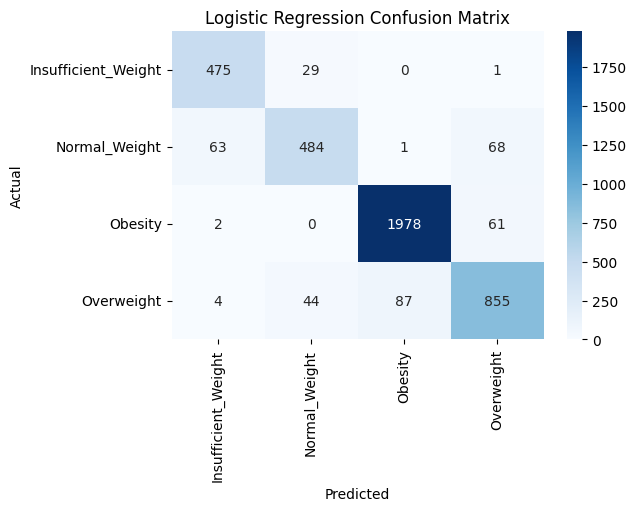

Logistic Regression Macro-AUC: 0.9850

K-Nearest Neighbors Accuracy: 0.8526
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.83      0.86      0.84       505
      Normal_Weight       0.68      0.70      0.69       616
            Obesity       0.94      0.95      0.95      2041
         Overweight       0.79      0.73      0.76       990

           accuracy                           0.85      4152
          macro avg       0.81      0.81      0.81      4152
       weighted avg       0.85      0.85      0.85      4152



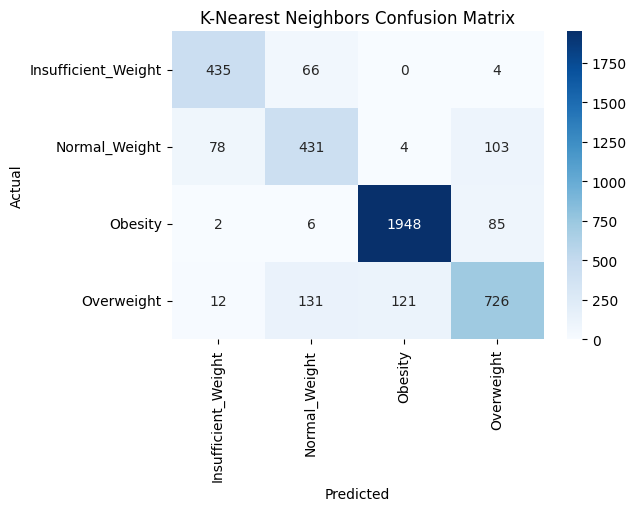

K-Nearest Neighbors Macro-AUC: 0.9529

Decision Tree Accuracy: 0.8943
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.88      0.88      0.88       505
      Normal_Weight       0.80      0.80      0.80       616
            Obesity       0.95      0.96      0.95      2041
         Overweight       0.84      0.82      0.83       990

           accuracy                           0.89      4152
          macro avg       0.87      0.87      0.87      4152
       weighted avg       0.89      0.89      0.89      4152



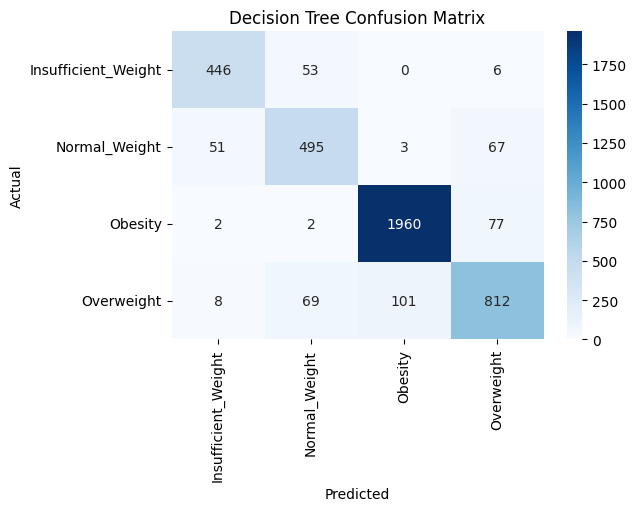

Decision Tree Macro-AUC: 0.9159

Support Vector Classifier Accuracy: 0.9171
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.92      0.91       505
      Normal_Weight       0.86      0.81      0.83       616
            Obesity       0.96      0.97      0.97      2041
         Overweight       0.87      0.87      0.87       990

           accuracy                           0.92      4152
          macro avg       0.90      0.89      0.89      4152
       weighted avg       0.92      0.92      0.92      4152



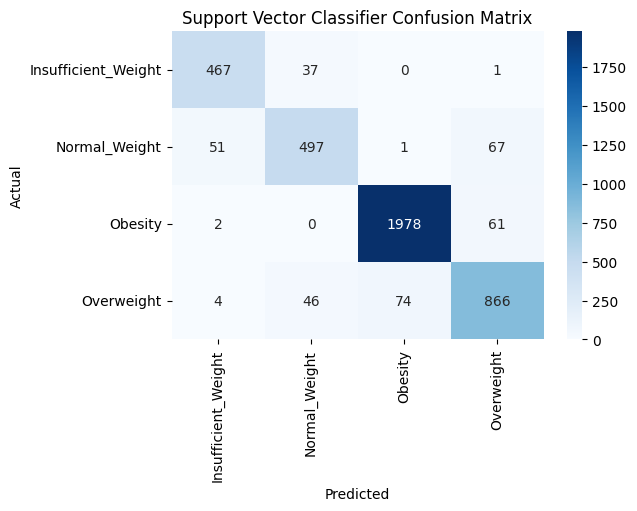

Support Vector Classifier Macro-AUC: 0.9873

MLP Classifier Accuracy: 0.9229
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.89      0.93      0.91       505
      Normal_Weight       0.86      0.83      0.85       616
            Obesity       0.97      0.97      0.97      2041
         Overweight       0.89      0.88      0.88       990

           accuracy                           0.92      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.92      0.92      0.92      4152



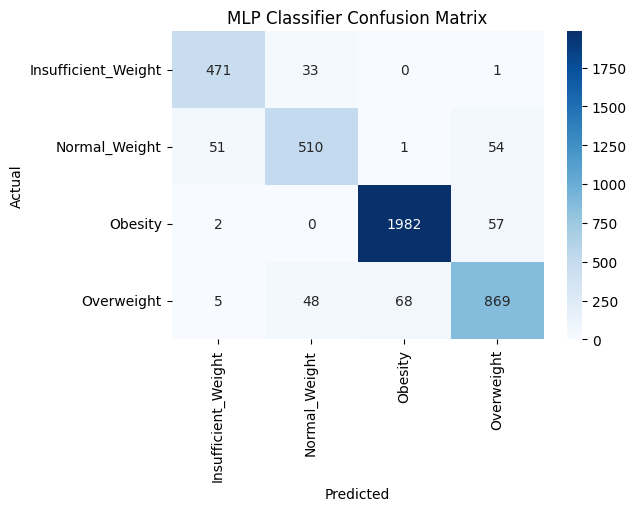

MLP Classifier Macro-AUC: 0.9880

Random Forest Accuracy: 0.9306
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.94      0.93       505
      Normal_Weight       0.86      0.87      0.87       616
            Obesity       0.97      0.97      0.97      2041
         Overweight       0.90      0.88      0.89       990

           accuracy                           0.93      4152
          macro avg       0.91      0.91      0.91      4152
       weighted avg       0.93      0.93      0.93      4152



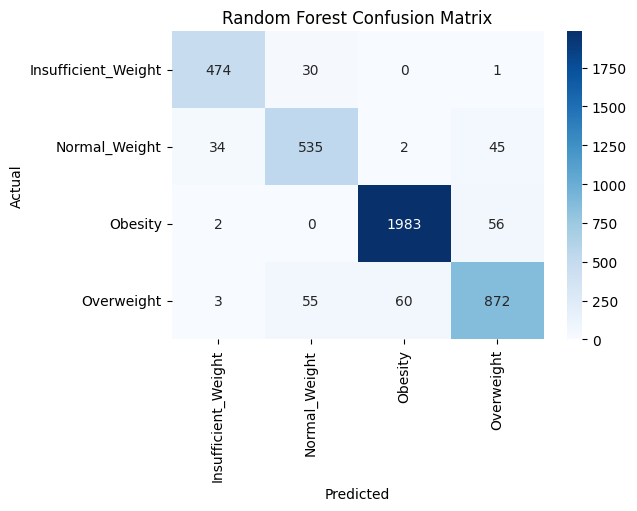

Random Forest Macro-AUC: 0.9886

XGBoost Accuracy: 0.9309
Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.92      0.95      0.93       505
      Normal_Weight       0.88      0.87      0.87       616
            Obesity       0.97      0.97      0.97      2041
         Overweight       0.89      0.88      0.89       990

           accuracy                           0.93      4152
          macro avg       0.91      0.92      0.92      4152
       weighted avg       0.93      0.93      0.93      4152



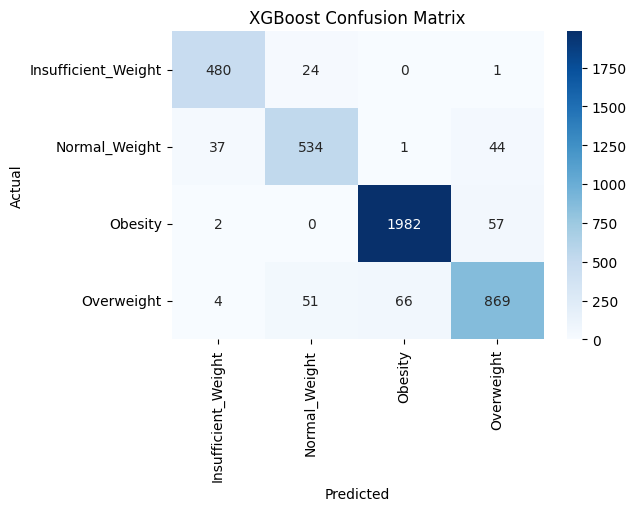

XGBoost Macro-AUC: 0.9913
Model Accuracy:
Logistic Regression: 0.9133
K-Nearest Neighbors: 0.8526
Decision Tree: 0.8943
Support Vector Classifier: 0.9171
MLP Classifier: 0.9229
Random Forest: 0.9306
XGBoost: 0.9309


/tmp/ipykernel_14693/2065844377.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


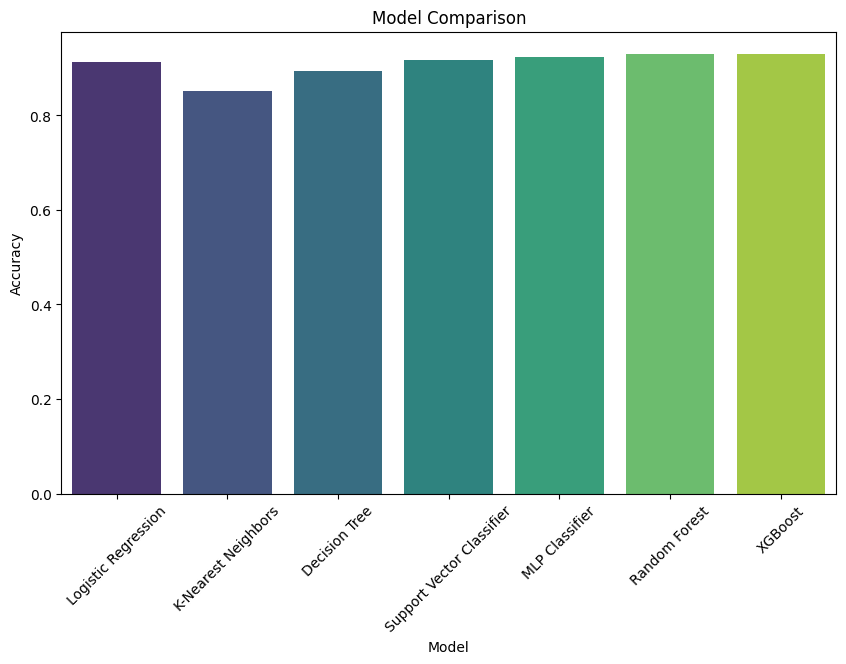

In [5]:

model_accuracies = {}

models = [
    (LogisticRegression(), "Logistic Regression"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (DecisionTreeClassifier(), "Decision Tree"),
    (SVC(probability=True), "Support Vector Classifier"),
    (MLPClassifier(max_iter=600), "MLP Classifier"),
    (RandomForestClassifier(), "Random Forest"),
    (XGBClassifier( eval_metric='logloss'), "XGBoost")
]


for model, name in models:
    accuracy = train_and_evaluate_model(model, name)
    model_accuracies[name] = accuracy

print("Model Accuracy:")
for name, accuracy in model_accuracies.items():
    print(f"{name}: {accuracy:.4f}")

plt.figure(figsize=(10, 6))
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title("Model Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()